In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model

In [2]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json", "r") as f:
    alldata = json.loads(f.read())

In [3]:
alldata.keys()

dict_keys(['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST'])

In [4]:
isone = alldata["ISONE CA"]

In [13]:
isone.keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt', 'SYSLoad', 'RegCP'])

In [42]:
slc = 361 * 24
cap = 365 * 24
demand = np.array(isone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(isone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2015 was Sunday, so starts with 0
days_of_week = [0, 1, 2, 3, 4, 5, 6]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), isone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc)

In [35]:
raw_temp = np.array(isone["DryBulb"])
temps= []
for year in range(10):
    for shift in range(9):
        offset = int(year * 365.24 + shift) * 24
        temps.append(raw_temp[offset: offset + slc])

In [36]:
temp = temps[0]
weekhour = week * hour
temp2 = temp ** 2
temp3 = temp ** 3
tempmonth = temp * month
temp2month = temp2 * month
temp3month = temp3 * month
temphour = temp * hour
temp2hour = temp2 * hour
temp3hour = temp3 * hour

<IPython.core.display.Javascript object>


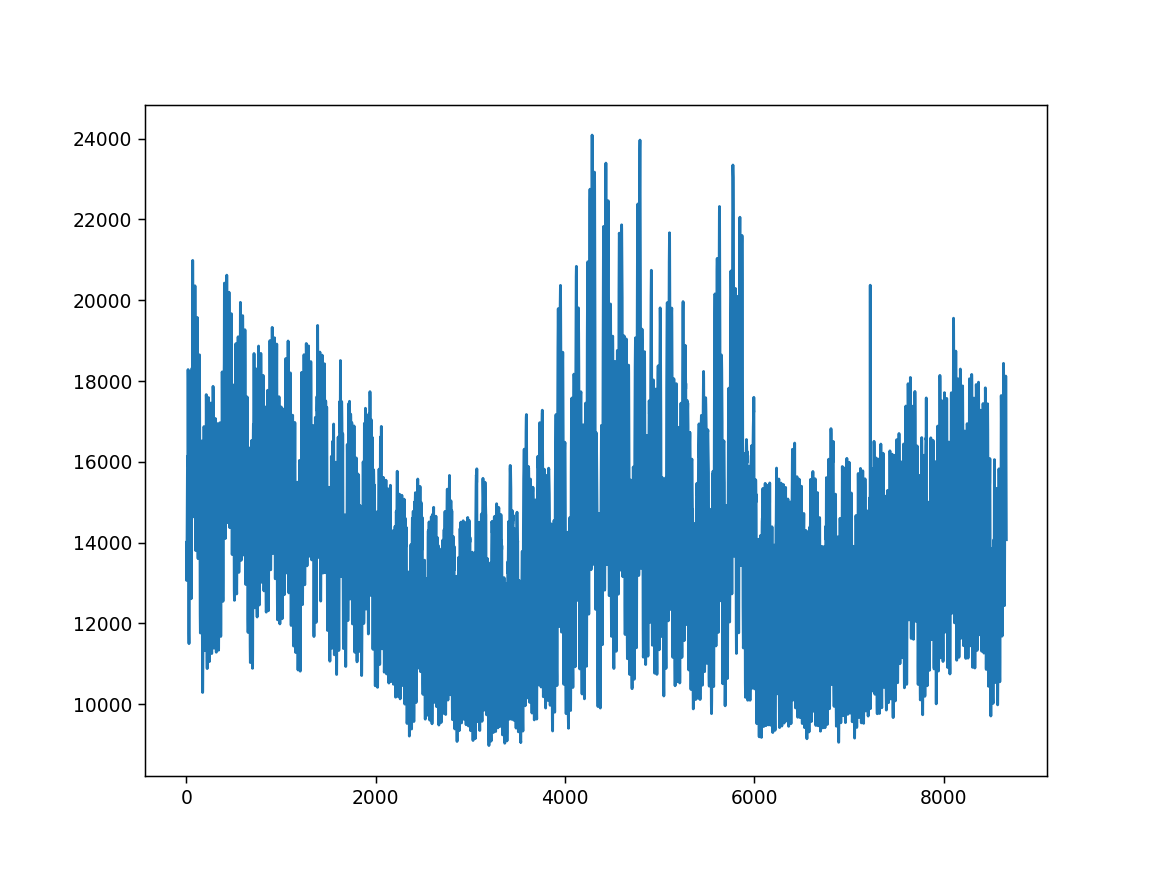

In [37]:
plt.figure()
plt.plot(demand)
plt.show()

In [39]:
reg = linear_model.LinearRegression()

variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
             temphour, temp2hour, temp3hour]
variables = list(map(list, zip(*variables)))  # transpose
reg.fit(variables, demand)

LinearRegression()

In [40]:
for i in range(len(variables[0])):
    print(reg.coef_[i])

-0.7944728503474351
327.92467890506117
126.25208084711193
251.2376978324316
-10.348339173162328
129.08076546614217
-7.3120912085175185
0.07580457280555564
6.6142542244662454
-0.0262379948568765
-0.0003465022375621629
-4.775491418710192
0.15519605473677167
-0.001426757593748107


<IPython.core.display.Javascript object>


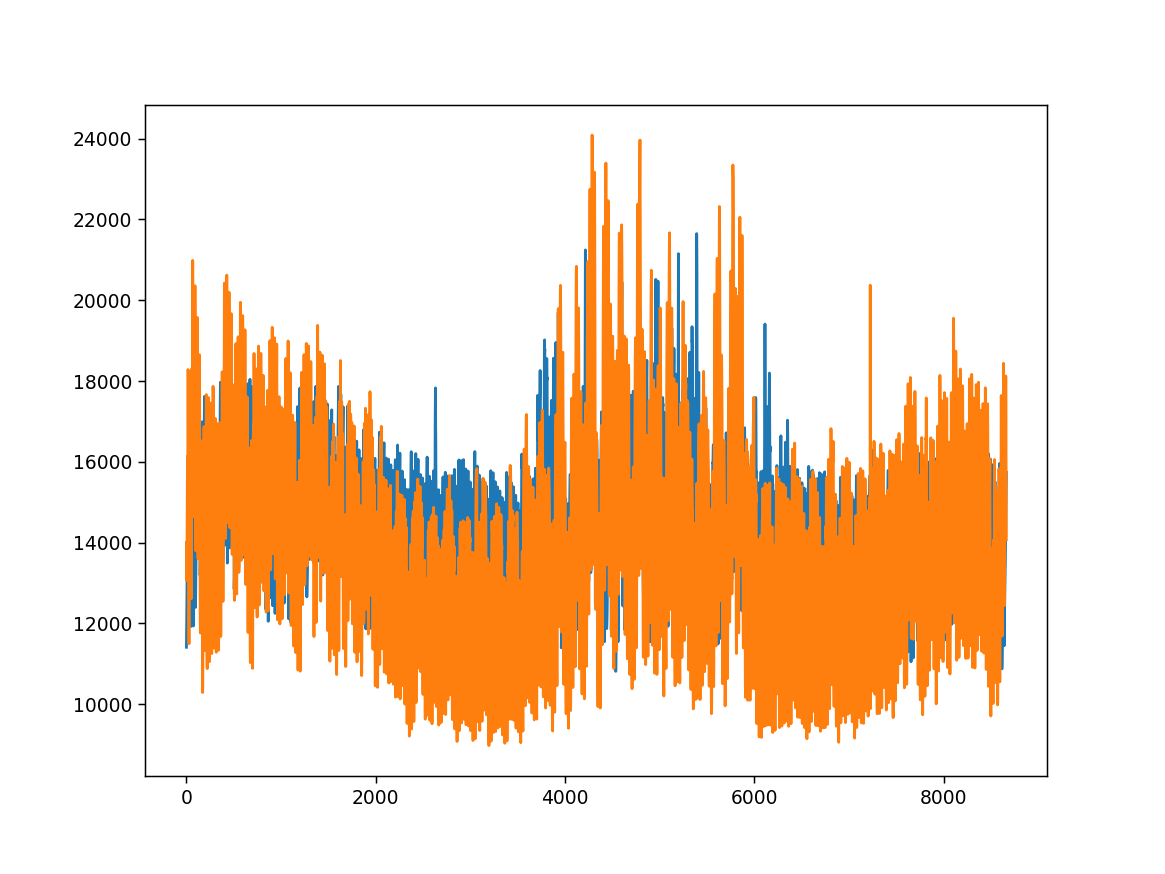

In [45]:
fit = reg.predict(variables)
plt.figure()
plt.plot(fit)
plt.plot(demand)
plt.show()

In [26]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2016.json", "r") as f:
    testdata = json.loads(f.read())

In [29]:
testisone = testdata["ISONE CA"]["DEMAND"]

In [ ]:
test

# Test

In [46]:
slc = 31 * 24
cap = (365 - 31) * 24
test_demand = np.array(isone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(isone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2015 was Sunday, so starts with 0
days_of_week = [0, 1, 2, 3, 4, 5, 6]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), isone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc)

In [47]:
temp = np.array(isone["DryBulb"][-(slc + cap):-cap])

In [48]:
weekhour = week * hour
temp2 = temp ** 2
temp3 = temp ** 3
tempmonth = temp * month
temp2month = temp2 * month
temp3month = temp3 * month
temphour = temp * hour
temp2hour = temp2 * hour
temp3hour = temp3 * hour
test_variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
             temphour, temp2hour, temp3hour]
test_variables = list(map(list, zip(*test_variables)))  # transpose

<IPython.core.display.Javascript object>


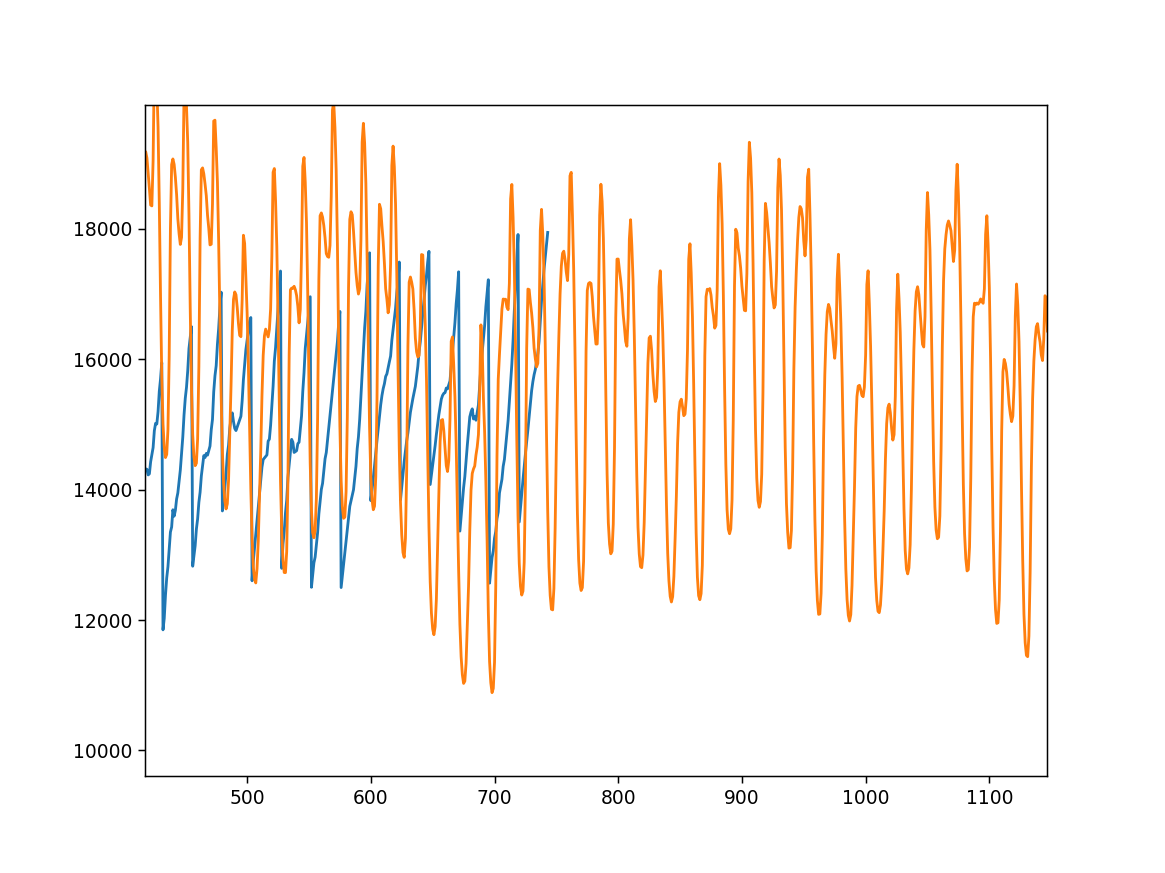

In [49]:
prediction = reg.predict(test_variables)
plt.figure()
plt.plot(prediction)
plt.plot(test_demand)
plt.show()